# Mountain Car

In [ ]:
!pip install gym[classic_control]

In [1]:
# Biblitecas necessárias
import gym
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from collections import deque
import random
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import HTML
import matplotlib.animation as animation

In [2]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [3]:
# Definindo a rede Q profunda
class DQN(nn.Module):
                    # (estado)     (ações)
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, x):
        x = F.relu(self.fc1(x.to(self.device)))
        x = F.relu(self.fc2(x.to(self.device)))
        x = self.fc3(x.to(self.device))
        return x

In [4]:
# Replay buffer (armazenar experiências)
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    # adicionar uma nova experiência
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    # selecionar uma amostra aleatoriamente de um lote de experiências do buffer.
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.array(state), action, reward, np.array(next_state), done

    # quantidade de experiências armazenadas no buffer
    def __len__(self):
        return len(self.buffer)

In [5]:
# DQN Agente
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.replay_buffer = ReplayBuffer(20000)
        self.batch_size = 64
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = DQN(state_dim, action_dim)
        self.model.to("cuda" if torch.cuda.is_available() else "cpu")
        self.target_model = DQN(state_dim, action_dim)
        self.target_model.to("cuda" if torch.cuda.is_available() else "cpu")
        self.optimizer = Adam(self.model.parameters(), lr=lr)
        self.update_target_model()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.model(state)
        return q_values.argmax().item()

    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)

        state = torch.FloatTensor(state).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        action = torch.LongTensor(action).to(self.device)
        reward = torch.FloatTensor(reward).to(self.device)
        done = torch.FloatTensor(done).to(self.device)

        q_values = self.model(state)
        next_q_values = self.target_model(next_state)
        q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        next_q_value = next_q_values.max(1)[0]
        expected_q_value = reward + self.gamma * next_q_value * (1 - done)

        loss = F.mse_loss(q_value, expected_q_value.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [8]:
# Trainando o agente
env = gym.make("MountainCar-v0")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQNAgent(state_dim, action_dim)

episodes = 5000  # Aumentar o número de episódios para dar mais tempo para o agente aprender
episode_rewards = []

for episode in range(episodes):
    state, _ = env.reset()
    episode_reward = 0
    done = False

    while not done:
        action = agent.select_action(state)
        next_state, reward, done, trunc, _ = env.step(action)
        done = done or trunc
        agent.replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward

        agent.train()

    episode_rewards.append(episode_reward)
    agent.update_target_model()
    if (episode+1) % 100 == 0 or (episode+1) == 1: 
        print(f"Episode {episode + 1}: {episode_reward}")

Episode 1: -200.0
Episode 100: -200.0
Episode 200: -200.0
Episode 300: -89.0
Episode 400: -153.0
Episode 500: -107.0
Episode 600: -106.0
Episode 700: -97.0
Episode 800: -86.0
Episode 900: -86.0
Episode 1000: -105.0
Episode 1100: -107.0
Episode 1200: -109.0
Episode 1300: -105.0
Episode 1400: -87.0
Episode 1500: -107.0


KeyboardInterrupt: 

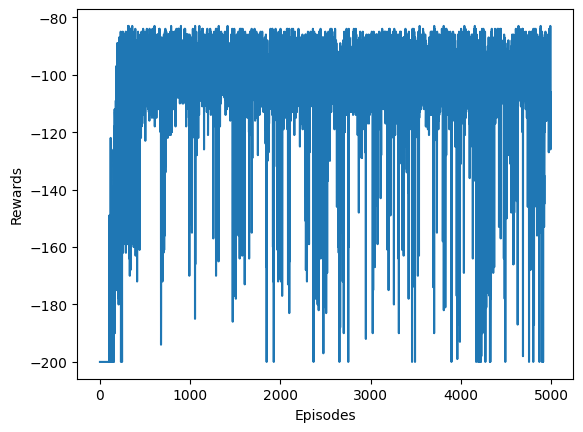

In [17]:
# plotando gráfico de recompensas
plt.plot(episode_rewards)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

In [18]:
# Record e display (video)
env = gym.make("MountainCar-v0", render_mode="rgb_array")
frames = []

for i in range(1):
    state, _ = env.reset()
    done = False
    score = 0

    while not done:
        frames.append(env.render())
        action = agent.select_action(state)
        next_state, reward, done, trunc, _ = env.step(action)
        done = done or trunc
        score += reward
        state = next_state

env.close()

In [19]:
# criar a animação
def create_animation(frames):
    rc('animation', html='jshtml')
    fig = plt.figure()
    plt.axis("off")
    im = plt.imshow(frames[0], animated=True)

    def updatefig(i):
        im.set_array(frames[i])
        return im,

    ani = animation.FuncAnimation(fig, updatefig, frames=len(frames), interval=50, blit=True)
    display(HTML(ani.to_html5_video()))
    plt.close()

    return ani

# Create and display the animation
create_animation(frames)

In [23]:
torch.save(agent.model, 'sample.pt')

In [9]:
env = gym.make("MountainCar-v0")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQNAgent(state_dim, action_dim)
agent.model = torch.load('sample.pt', weights_only=False)

In [3]:
print(type(HTML))

<class 'type'>
